In [1]:
from malade.omop_evaluation import *
from IPython.display import Image
import pandas as pd
import altair as alt
from sklearn.metrics import RocCurveDisplay, roc_curve, classification_report
from functools import partial
import re

# AUC

Computed from the model's confidence scores:

In [2]:
omop_auc(confidence, target_class=OMOPLabels.INCREASE)

0.8611111111111112

In [3]:
omop_auc(confidence, target_class=OMOPLabels.NO_EFFECT)

0.8388429752066116

2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


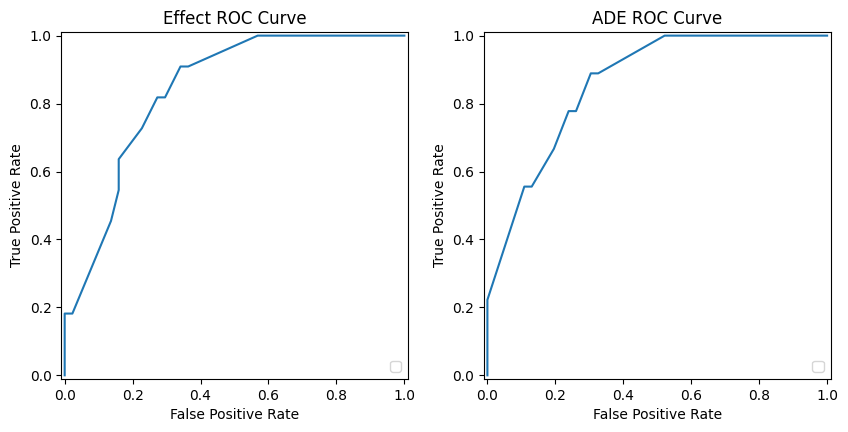

In [4]:
plot_rocs(path="img/roc_confidence.pdf")

Computed from the model's predicted probabilities of any event ocurring:

In [5]:
omop_auc(probability, target_class=OMOPLabels.INCREASE)

0.7487922705314008

In [6]:
omop_auc(probability, target_class=OMOPLabels.NO_EFFECT)

0.765495867768595

2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-17 00:09:17 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


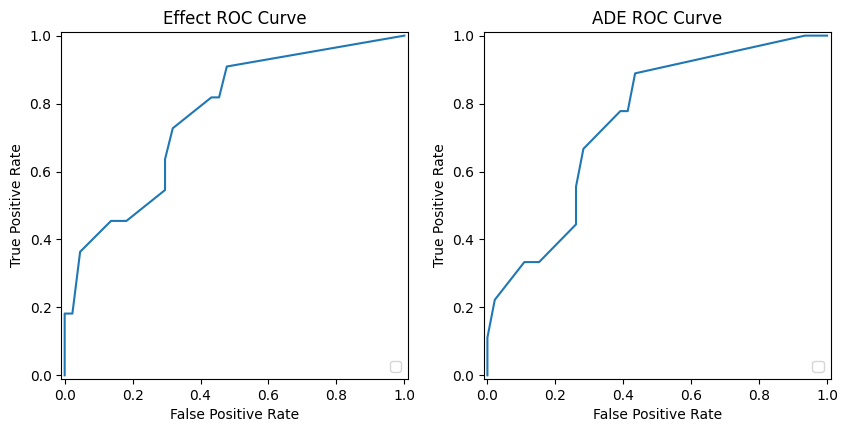

In [7]:
plot_rocs(probability, path="img/roc_probability.pdf")

## Sensitivity-specificity

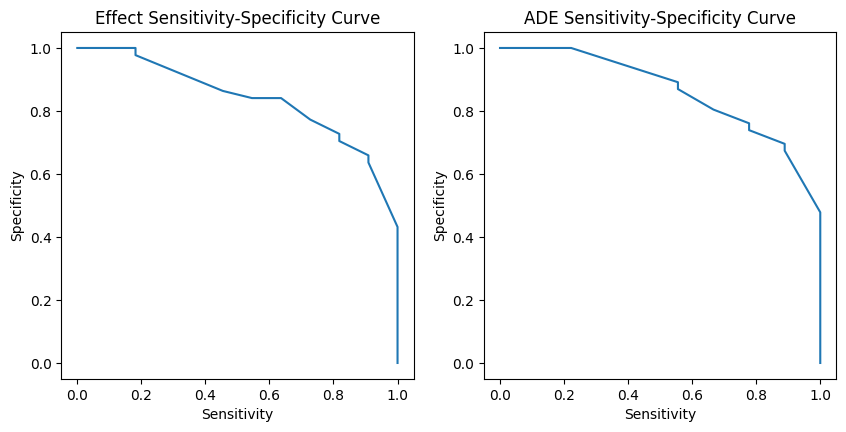

In [8]:
plot_sensitivity_specificity(confidence, path="img/sensitivity_specificity_confidence.pdf")

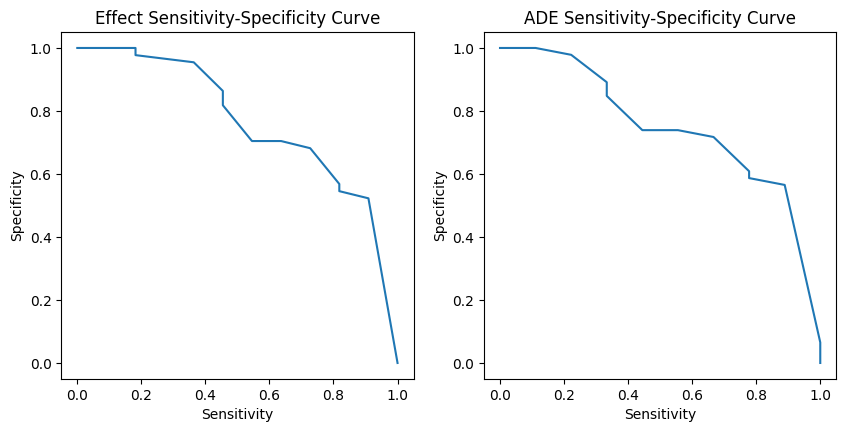

In [9]:
plot_sensitivity_specificity(probability, path="img/sensitivity_specificity_probability.pdf")

# Predicitions

In [10]:
plot_interactions(predicted_omop_table(exclude_fn=noop), save_to="img/omop_predicted_all.pdf")

alt.Chart(...)

In [11]:
plot_interactions(predicted_omop_table(exclude_fn=exclude_prob_or_rare_and_weak), save_to="img/omop_postprocessed.pdf")

alt.Chart(...)

In [12]:
plot_interactions(omop_table, save_to="img/omop_ground_truth.pdf")

alt.Chart(...)

# Evaluation of Predictions

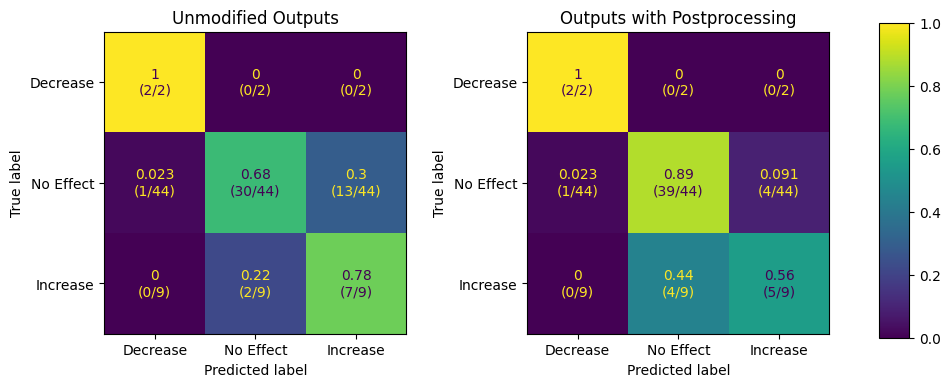

In [13]:
y, yhat = to_verified_labels(predicted_omop_table(interactions, noop))
label_map = {
    OMOPLabels.DECREASE: 0,
    OMOPLabels.NO_EFFECT: 1,
    OMOPLabels.INCREASE: 2,
}
y = [label_map[yi] for yi in y]
yhat = [label_map[yi] for yi in yhat]

fig, ax = plt.subplots(1, 2, figsize=(10,4.5))

im_kw={"vmin": 0, "vmax": 1}

_, im_ = omop_confusion(noop, ax=ax[0], colorbar=False, im_kw=im_kw)
ax[0].set_title("Unmodified Outputs")

omop_confusion(exclude_prob_or_rare_and_weak, ax=ax[1], colorbar=False, im_kw=im_kw)
ax[1].set_title("Outputs with Postprocessing")

fig.subplots_adjust(right=0.85, wspace=0.4)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
fig.colorbar(im_, cax=cbar_ax)

plt.savefig("img/confusion_matrix.pdf")
plt.show()

With postprocessing

In [14]:
omop_f1(exclude_prob_or_rare_and_weak)

{'Effect': 0.6086956521739131, 'ADE': 0.5555555555555556}

Without

In [15]:
omop_f1(noop)

{'Effect': 0.5294117647058824, 'ADE': 0.4827586206896552}

# Critic

In [16]:
feedback_regex = re.compile(r'FUNC\:\s*{\n\s*"name": "feedback"')

def get_drug_log(category: OMOPDrugs) -> str:
    path = f"logs/DrugFinder-{str(category.value)}.log"
    with open(path) as f:
        return f.read()

def get_drugs(category: OMOPDrugs) -> list[str]:
    return interactions.categories[str(category.value)].representative_drugs
    
def get_drug_outcome_log(drug: str, condition: OMOPConditions) -> str:
    path = f"logs/DrugOutcomeInfoAgent-{str(condition.value)}-{drug}.log"
    with open(path) as f:
        return f.read()

def get_classification_log(category: OMOPDrugs, condition: OMOPConditions) -> str:
    path = f"logs/CategoryOutcomeRiskAgent-{str(condition.value)}-{str(category.value)}.log"
    with open(path) as f:
        return f.read()

def critic_count(text: str) -> str:
    # Occurs twice per call to critic
    return len(feedback_regex.findall(text)) // 2

def mean(vals: list[float]) -> float:
    return sum(vals)/len(vals)

In [17]:
drug_counts = {cat: critic_count(get_drug_log(cat)) for cat in omop_drugs}
drug_outcome_counts = {
    (cat, condition, drug): critic_count(
        get_drug_outcome_log(drug, condition)
    ) 
    for cat in omop_drugs
    for condition in conditions
    for drug in get_drugs(cat)
}
classification_counts = {
    (cat, condition): critic_count(
        get_classification_log(cat, condition)
    ) 
    for cat in omop_drugs
    for condition in conditions
}

In [18]:
def to_dist(lst: list[int]) -> dict[int, float]:
    counts = {}

    for v in lst:
        if v not in counts:
            counts[v] = 1
        else:
            counts[v] += 1

    return {k: v/len(lst) for k, v in counts.items()}

def table(labeled_dicts):
    outputs = {}

    for name, critic_counts in labeled_dicts:
        count_dist = to_dist(list(critic_counts.values()))
        outputs[name] = {
            "0,1": count_dist.get(0, 0) + count_dist.get(1, 0),
            "2+": sum(c for i, c in count_dist.items() if i >= 2),
        }

    return outputs

In [19]:
table([
    ("DrugFinder", drug_counts),
    ("DrugOutcomeInfoAgent", drug_outcome_counts),
    ("CategoryOutcomeRiskAgent", classification_counts),
])

{'DrugFinder': {'0,1': 0.38461538461538464, '2+': 0.6153846153846154},
 'DrugOutcomeInfoAgent': {'0,1': 0.9575757575757575,
  '2+': 0.04242424242424242},
 'CategoryOutcomeRiskAgent': {'0,1': 0.5538461538461539,
  '2+': 0.4461538461538462}}